In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import os
import pickle

In [2]:
customer_info = pd.read_csv('../data/cleaned/customer_information_with_segments.csv')
#order_info = pd.read_csv('../data/cleaned/customer_information.csv')

In [3]:
display(customer_info.head())
display(customer_info.shape)

,user_id,registration_date,age,gender,city,country,first_order_date,last_order_date,total_orders,avg_order_items,...,days_betw_first_last_order,days_until_last_order,age_class,registration_year,registration_month,kmeans_cluster_wo_transf,kmeans_rfm_score_based,lifetime_yrs,revenue_per_lifetime_yrs,revenue_per_lifetime_days
0,18,2020-06-18 10:15:00+00:00,31,M,Schwedt/Oder,Poland,2021-05-26 10:15:00+00:00,2021-05-26 10:15:00+00:00,1,1.0,...,0.0,342.0,31-40,2020,6,0,1,0.000000,inf,46.990002
1,29,2023-09-22 07:18:00+00:00,23,M,Pudsey,United Kingdom,2023-11-29 07:18:00+00:00,2023-11-29 07:18:00+00:00,1,2.0,...,0.0,68.0,19-30,2023,9,2,0,0.000000,inf,65.680000
2,33,2019-02-14 17:19:00+00:00,12,M,Bogatynia,Poland,2020-06-02 17:19:00+00:00,2020-06-11 17:19:00+00:00,2,1.0,...,9.0,483.0,0-18,2019,2,0,1,0.024658,2999.488852,8.217778
3,49,2023-04-11 02:46:00+00:00,62,M,Bailleul,France,2023-08-20 02:46:00+00:00,2023-08-20 02:46:00+00:00,1,1.0,...,0.0,131.0,61-70,2023,4,2,0,0.000000,inf,65.000000
4,50,2023-05-01 13:46:00+00:00,15,F,Linares,Spain,2023-07-10 13:46:00+00:00,2023-09-27 13:46:00+00:00,2,1.5,...,79.0,149.0,0-18,2023,5,2,2,0.216438,2368.988633,6.490380


(14047, 28)

In [4]:
numerical_cols = customer_info.select_dtypes(include='number').columns
categorical_cols = customer_info.select_dtypes(exclude='number').columns

# Checking overall correlation between variables
correlation_matrix = customer_info[numerical_cols].corr().round(4)
correlation_matrix

,user_id,age,total_orders,avg_order_items,total_revenue,avg_order_value,avg_days_between_orders,order_frequency_per_year,days_since_first_order,days_since_last_order,...,days_until_first_order,days_betw_first_last_order,days_until_last_order,registration_year,registration_month,kmeans_cluster_wo_transf,kmeans_rfm_score_based,lifetime_yrs,revenue_per_lifetime_yrs,revenue_per_lifetime_days
user_id,1.0000,-0.0201,-0.0021,-0.0018,-0.0001,-0.0032,0.0059,-0.0033,-0.0003,-0.0055,...,-0.0070,0.0070,-0.0015,0.0023,0.0156,0.0106,0.0028,0.0070,-0.0165,-0.0048
age,-0.0201,1.0000,-0.0048,-0.0005,-0.0208,-0.0241,0.0028,0.0107,0.0004,0.0032,...,-0.0135,-0.0037,-0.0144,0.0108,-0.0076,-0.0010,0.0014,-0.0037,0.0055,-0.0143
total_orders,-0.0021,-0.0048,1.0000,0.0111,0.7801,0.5237,0.4737,-0.0396,0.2410,-0.2366,...,-0.2360,0.6900,0.2473,-0.0293,-0.0054,-0.0556,0.4752,0.6900,-0.0448,-0.3664
avg_order_items,-0.0018,-0.0005,0.0111,1.0000,0.2079,0.4023,0.0065,-0.0115,-0.0021,-0.0086,...,0.0046,0.0084,0.0096,-0.0020,0.0012,-0.0068,-0.0530,0.0084,0.0830,0.3968
total_revenue,-0.0001,-0.0208,0.7801,0.2079,1.0000,0.8652,0.2946,-0.0222,0.1643,-0.1862,...,-0.1782,0.5040,0.1755,-0.0088,0.0033,-0.0929,0.4387,0.5040,0.0816,-0.0646
avg_order_value,-0.0032,-0.0241,0.5237,0.4023,0.8652,1.0000,0.2402,-0.0095,0.1014,-0.1442,...,-0.1307,0.3506,0.1162,0.0080,0.0097,-0.0559,0.2483,0.3506,0.1558,0.3308
avg_days_between_orders,0.0059,0.0028,0.4737,0.0065,0.2946,0.2402,1.0000,-0.0537,0.4581,-0.1434,...,-0.1489,0.8974,0.4603,-0.2651,-0.0501,0.0768,0.0804,0.8974,-0.1789,-0.3077
order_frequency_per_year,-0.0033,0.0107,-0.0396,-0.0115,-0.0222,-0.0095,-0.0537,1.0000,-0.1481,-0.1279,...,-0.0267,-0.0546,-0.0595,0.1312,0.0588,0.0847,-0.0668,-0.0546,0.3676,0.0440
days_since_first_order,-0.0003,0.0004,0.2410,-0.0021,0.1643,0.1014,0.4581,-0.1481,1.0000,0.7673,...,-0.1622,0.4985,0.1859,-0.6949,-0.1193,-0.6790,0.1862,0.4985,-0.1770,-0.1413
days_since_last_order,-0.0055,0.0032,-0.2366,-0.0086,-0.1862,-0.1442,-0.1434,-0.1279,0.7673,1.0000,...,-0.0533,-0.1734,-0.1610,-0.5831,-0.0999,-0.7749,0.0161,-0.1734,-0.0460,0.0755


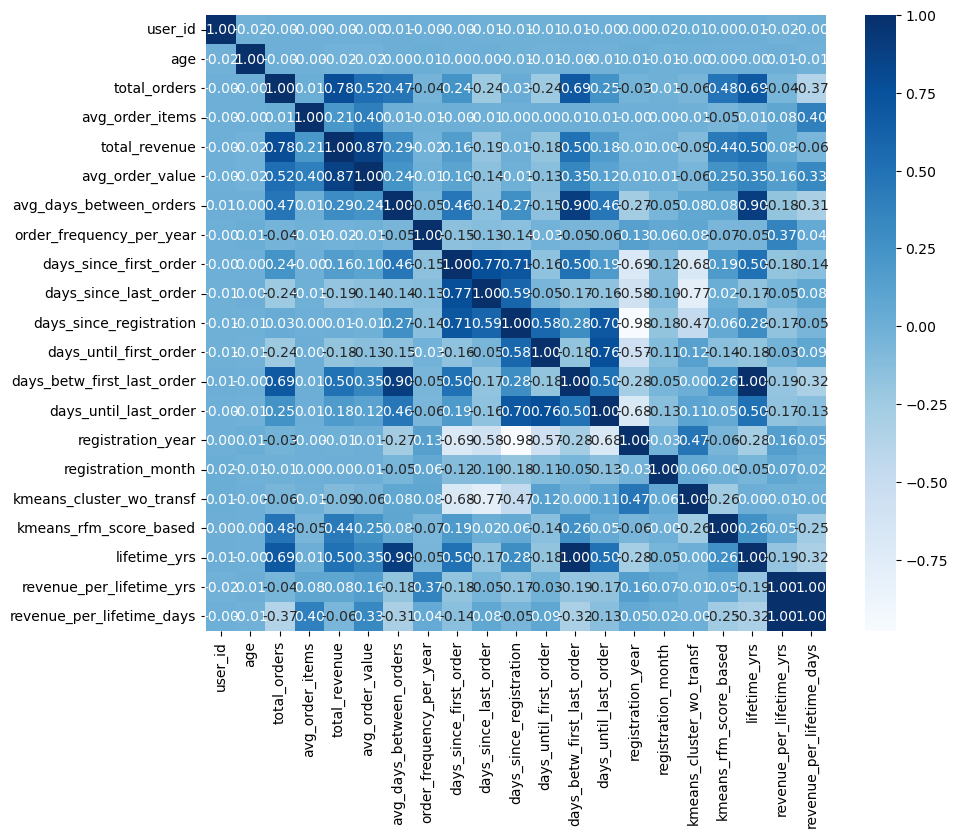

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.show()

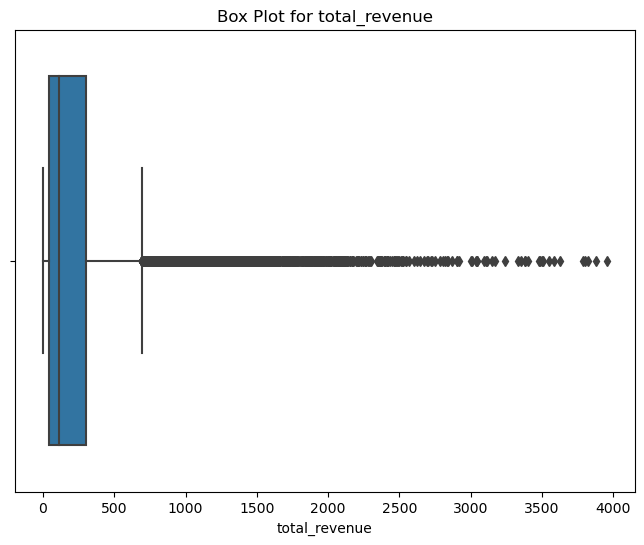

In [6]:
# CCheck again distribution / outliers for target column
plt.figure(figsize=(8, 6)) 
sns.boxplot(x=customer_info['total_revenue'])
plt.title(f'Box Plot for total_revenue')
plt.show()

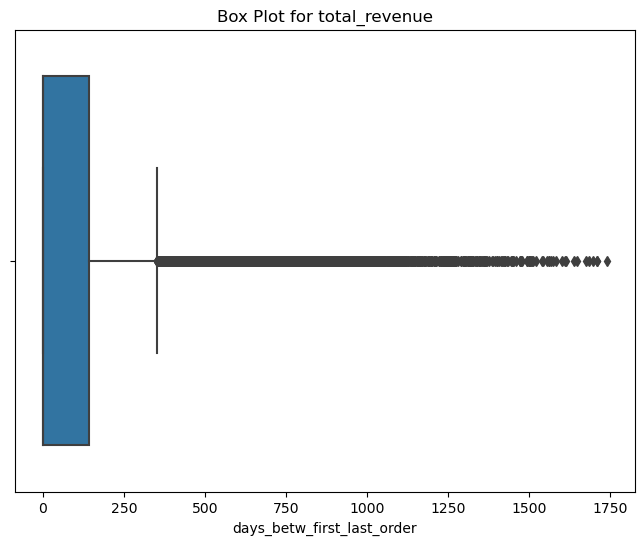

In [7]:
# Create box plots for numerical columns

plt.figure(figsize=(8, 6)) 
sns.boxplot(x=customer_info['days_betw_first_last_order'])
plt.title(f'Box Plot for total_revenue')
plt.show()

In [8]:
# after a first round of evaluating the models, it was decided to further cut out outliers

#drop customers with total_revenue > 3000
customer_info = customer_info[customer_info['total_revenue'] <= 3000]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = customer_info[['total_orders', 'days_since_last_order',
                   'days_betw_first_last_order', 'kmeans_cluster_wo_transf']]
y = customer_info['total_revenue']

# Split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

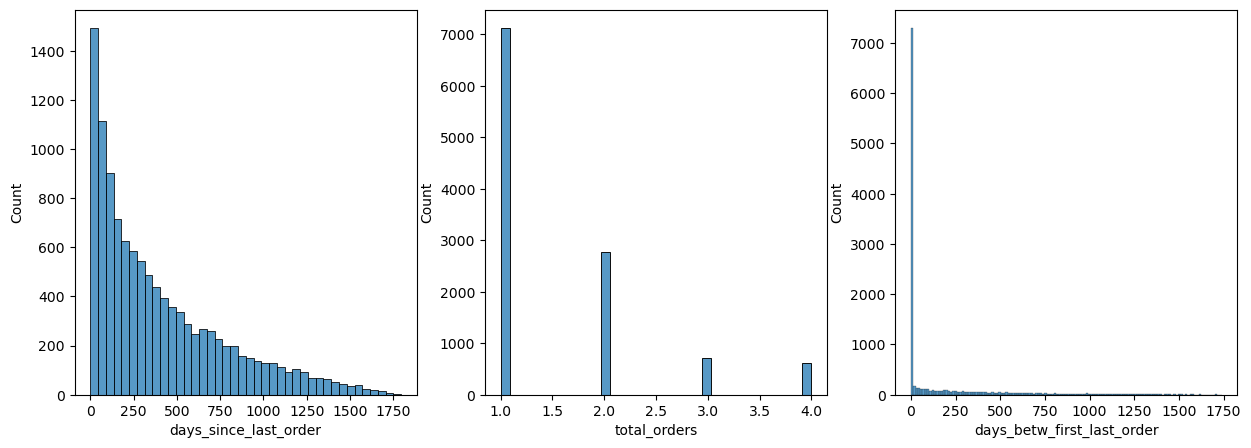

In [10]:
# The variables shouldn't be skewed and should have the same mean and variance. Let's check:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(X_train, x='days_since_last_order', ax=ax[0])
sns.histplot(X_train, x='total_orders', ax=ax[1])
sns.histplot(X_train, x='days_betw_first_last_order', ax=ax[2])
plt.show()

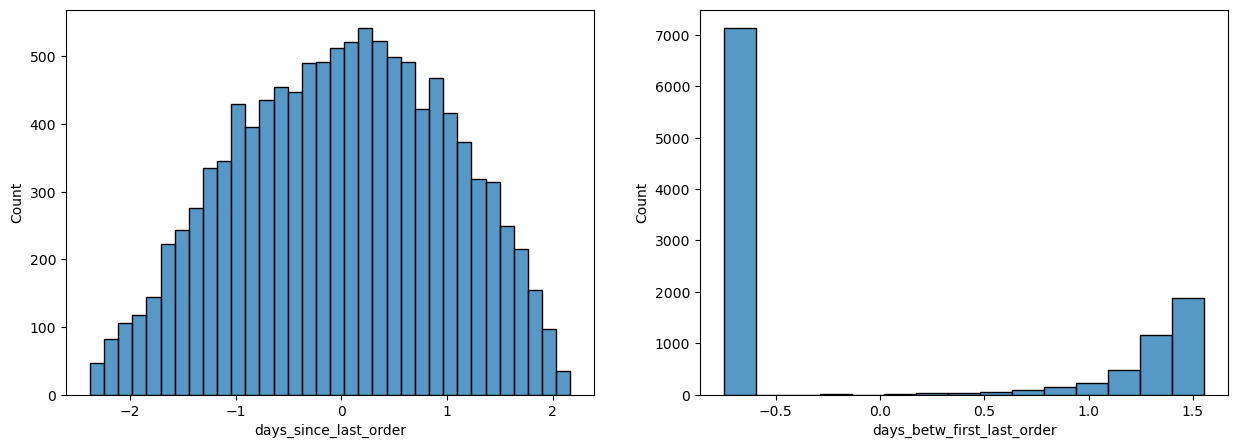

In [11]:
to_be_transformed_df = X_train[['days_since_last_order', 'days_betw_first_last_order']]
transformer = PowerTransformer()
X_train_transformed = transformer.fit_transform(to_be_transformed_df)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=to_be_transformed_df.columns,
                                     index=to_be_transformed_df.index)
path = "../transformers/"
# Check whether the specified path exists or not
import os
isExist = os.path.exists(path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)
    print("The new directory is created!")

filename = "transformer_lin_reg.pkl"    
with open(path + filename, "wb") as file:
    pickle.dump(transformer, file)
    
    
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(X_train_transformed_df, x='days_since_last_order', ax=ax[0])
sns.histplot(X_train_transformed_df, x='days_betw_first_last_order', ax=ax[1])
plt.show()

In [12]:
X_train_transformed_df = pd.concat([X_train[['total_orders', 'kmeans_cluster_wo_transf']],
                            X_train_transformed_df], axis=1)
X_train_transformed_df.head()

,total_orders,kmeans_cluster_wo_transf,days_since_last_order,days_betw_first_last_order
3628,1,2,0.617303,-0.747488
12239,1,2,-0.557594,-0.747488
13518,1,2,-1.325852,-0.747488
733,3,1,0.443788,1.532584
5592,1,2,0.547654,-0.747488


In [13]:
X_test_transformed = transformer.transform(X_test[['days_since_last_order', 'days_betw_first_last_order']])
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=to_be_transformed_df.columns,
                                    index=X_test.index)
X_test_transformed_df = pd.concat([X_test[['total_orders', 'kmeans_cluster_wo_transf']],
                            X_test_transformed_df], axis=1)
X_test_transformed_df.head()

,total_orders,kmeans_cluster_wo_transf,days_since_last_order,days_betw_first_last_order
3944,1,0,1.220175,-0.747488
7231,1,2,-0.649503,-0.747488
11643,1,0,1.668212,-0.747488
1770,4,1,0.528474,1.513660
4841,3,1,-1.251476,1.106500


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_transformed_df)
X_test_scaled = scaler.transform(X_test_transformed_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_transformed_df.columns,
                                    index=X_train_transformed_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_transformed_df.columns,
                                    index=X_test_transformed_df.index)

path = "../scalers/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)
    print("The new directory is created!")

scaler_file_name = "min_max_scaler_lin_reg.pkl"    
with open(path + scaler_file_name, "wb") as file:
    pickle.dump(scaler, file)

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled_df, y_train)

path = "../models/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)
    print("The new directory is created!")
        
filename = "linear_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(lin_reg, file)

In [16]:
y_train_pred = lin_reg.predict(X_train_scaled_df)
y_test_pred = lin_reg.predict(X_test_scaled_df)

In [17]:
def error_metrics(y_train_pred: str, y_test_pred: str):
    """Generate error metrics report based on predictions of the model
    """
    # Evaluate the model
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Create a DataFrame with the error metrics
    error_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
        'Train': [mae_train, mse_train, rmse_train, r2_train],
        'Test': [mae_test, mse_test, rmse_test, r2_test]})

    return error_df

In [18]:
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,135.185986,134.251218
1,MSE,52465.221580,52905.316824
2,RMSE,229.052879,230.011558
3,R2,0.651345,0.650359


The coefficient for the first feature is approximately 0.33.
Interpretation: A one-unit increase in this feature is associated with a 0.33 increase in the target variable, holding other features constant.
The coefficient for the second feature is approximately -0.14.
Interpretation: A one-unit increase in this feature is associated with a 0.14 decrease in the target variable, holding other features constant.
The coefficient for the third feature is approximately -0.03.
Interpretation: A one-unit increase in this feature is associated with a 0.03 decrease in the target variable, holding other features constant.
Overall, your model seems to have low errors based on the MAE, MSE, and RMSE metrics. The R2 value indicates a moderate level of explanatory power, suggesting that the model captures some of the variance in the target variable. 

R2 is the same for the train and test sets. Therefore, we do not have any overfitting or underfitting of the model.

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)
model = rf_reg.fit(X_train, y_train) # performance is not better with transformed & scaled data

path = "../models/"
filename = "random_forest_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(rf_reg, file)
    
# Make predictions on the training and test sets
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

In [20]:
error_metrics(y_train_pred, y_test_pred)
#error_metrics(rf_reg, X_train_transformed_df, X_test_transformed_df)

,Metric,Train,Test
0,MAE,51.064732,134.763949
1,MSE,7379.440988,50800.895604
2,RMSE,85.903673,225.390540
3,R2,0.950960,0.664267


In [21]:
names = rf_reg.feature_names_in_
values = rf_reg.feature_importances_

rf_best_features = pd.DataFrame({"Name":names, "value":values})
rf_best_features.sort_values(by="value", ascending=False)

,Name,value
0,total_orders,0.630945
1,days_since_last_order,0.169412
2,days_betw_first_last_order,0.132799
3,kmeans_cluster_wo_transf,0.066844


The cross_val_score function in scikit-learn is used for cross-validated scoring of a given estimator (model) on a dataset. Cross-validation is a technique to assess how well a model generalizes to an independent dataset. The function splits the dataset into multiple subsets (folds), and the model is trained and evaluated multiple times, each time using a different subset as the test set and the remaining data as the training set.

In [22]:
#default score R2
cross_val_scores = cross_val_score(rf_reg, X_train, y_train, cv=10)
cross_val_scores

array([0.68182495, 0.67900831, 0.63788176, 0.62391839, 0.67691795,
       0.57825214, 0.66575129, 0.6644167 , 0.65714574, 0.58513207])

R2 measures the proportion of variance in the dependent variable explained by the independent variables.
The R2 value for the train set has increased significantly, indicating a better fit. However, the R2 value for the test set is relatively low, suggesting that the model might not generalize well to unseen data

In [84]:
from sklearn.model_selection import GridSearchCV

# Create another RandomForestRegressor
#rf_reg2 = RandomForestRegressor(random_state=42)

# Define the parameter grid to search
rf_param_grid = {
    'n_estimators': [50, 100, 150], # common values to explore
    'max_depth': [5, 10, 20], #A higher max_depth captures more complex patterns in the data, but it also increases the risk of overfitting.
    'min_samples_split': [2, 5, 10], #minimum number of samples required to split an internal node. Higher values can prevent the model from splitting nodes that have too few samples, helping to control overfitting. 
    'min_samples_leaf': [1, 2, 4], #minimum number of samples required to be at a leaf node. Similar to min_samples_split, higher values can help control overfitting by requiring a minimum number of samples in each leaf.
    'max_features': ['sqrt', 'log2']
}

# Create a GridSearchCV object with precision as the scoring metric
#grid_search = GridSearchCV(rf_classifier, scorer=scorer, param_grid, cv=5)
rf_grid_search = GridSearchCV(rf_reg, rf_param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose = 20)

# Fit the model using GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and the best precision score
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 2/5; 1/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 1/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.722, test=0.708) total time=   1.0s
[CV 5/5; 1/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 5/5; 1/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.727, test=0.699) total time=   0.7s
[CV 4/5; 2/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 2/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.720, test=0.717) total time=   1.8s
[CV 3/5; 3/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 

[CV 4/5; 1/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 4/5; 1/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.719, test=0.716) total time=   0.8s
[CV 3/5; 2/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 2/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.726, test=0.708) total time=   1.7s
[CV 2/5; 3/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 2/5; 3/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=0.724, test=0.712) total time=   3.0s
[CV 1/5; 4/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/5; 4/162] END max_depth=5, max_features=sqrt, min_samples_le

[CV 3/5; 1/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 1/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.725, test=0.708) total time=   1.3s
[CV 1/5; 2/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 2/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.722, test=0.721) total time=   1.8s
[CV 5/5; 2/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 5/5; 2/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.727, test=0.697) total time=   1.9s
[CV 4/5; 3/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 4/5; 3/162] END max_depth=5, max_features=sqrt, min_samples_l

[CV 1/5; 1/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 1/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.720, test=0.719) total time=   1.1s
[CV 2/5; 2/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 2/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.724, test=0.711) total time=   2.0s
[CV 1/5; 3/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/5; 3/162] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=0.722, test=0.721) total time=   2.9s
[CV 5/5; 3/162] START max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 5/5; 3/162] END max_depth=5, max_features=sqrt, min_samples_l

[CV 1/5; 49/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=(train=0.720, test=0.719) total time=   1.0s[CV 5/5; 45/162] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150;, score=(train=0.727, test=0.698) total time=   2.9s
[CV 2/5; 47/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 2/5; 47/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.723, test=0.711) total time=   1.3s
[CV 1/5; 48/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 1/5; 48/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.720, test=0.719) total time=   3.1s
[CV 5/5; 48/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 5/


[CV 4/5; 49/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50
[CV 4/5; 49/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=(train=0.718, test=0.715) total time=   0.9s
[CV 4/5; 50/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 4/5; 50/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.719, test=0.714) total time=   1.6s
[CV 3/5; 51/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150
[CV 3/5; 51/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150;, score=(train=0.724, test=0.708) total time=   2.8s
[CV 2/5; 52/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 2/5; 52/162] END max_depth=5, max_features=log2, min_

[CV 4/5; 47/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.719, test=0.714) total time=   1.2s
[CV 3/5; 48/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 3/5; 48/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.724, test=0.708) total time=   4.5s
[CV 2/5; 49/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50
[CV 2/5; 49/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=(train=0.722, test=0.709) total time=   1.2s
[CV 1/5; 50/162] START max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 1/5; 50/162] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.721, test=0.719) total time=   1.7s
[CV 5/5

[CV 5/5; 83/162] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.803, test=0.687) total time=   3.4s
[CV 4/5; 84/162] START max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 4/5; 84/162] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=0.797, test=0.720) total time=   4.8s
[CV 3/5; 85/162] START max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 3/5; 85/162] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.795, test=0.696) total time=   1.7s
[CV 1/5; 86/162] START max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/5; 86/162] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.792, test=0.719) total time=   3.8s


[CV 2/5; 90/162] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.780, test=0.707) total time=   4.8s
[CV 1/5; 91/162] START max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 1/5; 91/162] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=0.787, test=0.715) total time=   1.6s
[CV 4/5; 91/162] START max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 4/5; 91/162] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=0.784, test=0.720) total time=   1.3s
[CV 3/5; 92/162] START max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/5; 92/162] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=0.794, test=0.697) total time=   3.4s
[

[CV 1/5; 123/162] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150
[CV 1/5; 123/162] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150;, score=(train=0.865, test=0.704) total time=  11.3s
[CV 5/5; 123/162] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150
[CV 5/5; 123/162] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150;, score=(train=0.866, test=0.663) total time=   9.9s
[CV 2/5; 125/162] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 2/5; 125/162] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.835, test=0.690) total time=   6.0s
[CV 1/5; 126/162] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150
[CV 1/5; 126/162] END max_depth=20, max

In [85]:
rf_best_model

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      random_state=42)

In [86]:
names = rf_best_model.feature_names_in_
values = rf_best_model.feature_importances_

rf_best_features = pd.DataFrame({"Name":names, "value":values})
rf_best_features.sort_values(by="value", ascending=False)

,Name,value
0,total_orders,0.585997
3,kmeans_cluster_wo_transf,0.196722
2,days_betw_first_last_order,0.164167
1,days_since_last_order,0.053114


In [87]:
from sklearn.model_selection import cross_val_score
rf_clf = rf_grid_search.best_estimator_
rf_clf_cross_val_scores = cross_val_score(rf_clf, X_train, y_train, cv=10)
rf_clf_cross_val_scores

array([0.71921002, 0.72425446, 0.70461721, 0.72277531, 0.733385  ,
       0.67394056, 0.72273183, 0.71286226, 0.72225038, 0.67048408])

In [139]:
# function error metrics fits best model, predicts X_test and gives the scores: 
# Make predictions on the training and test sets
y_train_pred = rf_best_model.predict(X_train)
y_test_pred = rf_best_model.predict(X_test)

path = "../models/"
filename = "random_forest_tuned_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(rf_best_model, file)
    
rf_best_model_metrics = error_metrics(y_train_pred, y_test_pred)
rf_best_model_metrics

,Metric,Train,Test
0,MAE,122.280822,120.973982
1,MSE,41796.904205,42115.405282
2,RMSE,204.442912,205.220382
3,R2,0.722241,0.721667


It's essential to note that while hyperparameter tuning aims to improve model performance, the impact may not always be dramatic. The resulting model might have a trade-off between bias and variance. Additionally, the complexity of the data and the nature of the problem play a role in determining the optimal hyperparameter values.

In conclusion, the model with tuned hyperparameters shows improvements in some metrics but might not result in a significant boost in performance. Further experimentation and tuning or trying different models could be explored for potential improvements.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

X = customer_info[['total_orders', 'days_since_last_order', 'days_since_registration',
                   'days_betw_first_last_order', 'kmeans_cluster_wo_transf']]
y = customer_info['total_revenue']

# Split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

path = "../models/"
filename = "gradient_boosting_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(gb_model, file)

# Make predictions on both training and testing sets
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

# Evaluate the model
gb_model_metrics  = error_metrics(y_train_pred, y_test_pred)
gb_model_metrics

,Metric,Train,Test
0,MAE,119.748539,121.273716
1,MSE,39165.353455,42213.721832
2,RMSE,197.902384,205.459782
3,R2,0.739729,0.721018


It's essential to note that while hyperparameter tuning aims to improve model performance, the impact may not always be dramatic. The resulting model might have a trade-off between bias and variance. Additionally, the complexity of the data and the nature of the problem play a role in determining the optimal hyperparameter values.

In conclusion, the model with tuned hyperparameters shows improvements in some metrics but might not result in a significant boost in performance. Further experimentation and tuning or trying different models could be explored for potential improvements.

In [24]:
from sklearn.model_selection import cross_val_score
gb_cross_val_scores = cross_val_score(gb_model, X_train, y_train, cv=10)
gb_cross_val_scores

array([0.71980672, 0.72053457, 0.70506558, 0.71857754, 0.72576692,
       0.66064585, 0.7163658 , 0.71057042, 0.7030218 , 0.66861433])

In [25]:
names = gb_model.feature_names_in_
values = gb_model.feature_importances_

rf_best_features = pd.DataFrame({"Name":names, "value":values})
rf_best_features.sort_values(by="value", ascending=False)

,Name,value
0,total_orders,0.882468
4,kmeans_cluster_wo_transf,0.080650
3,days_betw_first_last_order,0.016078
2,days_since_registration,0.011639
1,days_since_last_order,0.009165


In [101]:
# Define the parameter grid to search
gb_param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to be run
    'learning_rate': [0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [2, 3, 5],  # Maximum depth of the individual trees
    'subsample': [0.6, 0.8],  # Fraction of samples used for fitting the trees
    'min_samples_split': [2, 3, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object with precision as the scoring metric
#grid_search = GridSearchCV(rf_classifier, scorer=scorer, param_grid, cv=5)
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose = 20)

# Fit the model using GridSearchCV
gb_grid_search.fit(X_train, y_train)

# Get the best parameters and the best precision score
gb_best_params = gb_grid_search.best_params_
gb_best_model = gb_grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6
[CV 1/5; 1/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6;, score=(train=0.680, test=0.678) total time=   1.2s
[CV 1/5; 2/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8
[CV 1/5; 2/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8;, score=(train=0.681, test=0.679) total time=   1.3s
[CV 1/5; 3/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6
[CV 1/5; 3/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6;, score=(train=0.699, test=0.694) total time=   2.9s
[CV 5/5; 3/324] START lea

[CV 2/5; 1/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6
[CV 2/5; 1/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6;, score=(train=0.680, test=0.676) total time=   1.2s
[CV 3/5; 2/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8
[CV 3/5; 2/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8;, score=(train=0.681, test=0.673) total time=   1.4s
[CV 2/5; 3/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6
[CV 2/5; 3/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6;, score=(train=0.699, test=0.691) total time=   3.0s
[CV 1/5; 4/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_spl

[CV 4/5; 1/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6
[CV 4/5; 1/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6;, score=(train=0.678, test=0.682) total time=   1.2s
[CV 5/5; 1/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6
[CV 5/5; 1/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.6;, score=(train=0.683, test=0.663) total time=   1.0s
[CV 4/5; 2/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8
[CV 4/5; 2/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8;, score=(train=0.679, test=0.684) total time=   1.3s
[CV 3/5; 3/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=1, min_samples_split

[CV 5/5; 164/324] START learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8
[CV 5/5; 164/324] END learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8;, score=(train=0.705, test=0.679) total time=   1.2s
[CV 4/5; 165/324] START learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6
[CV 4/5; 165/324] END learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6;, score=(train=0.717, test=0.704) total time=   1.9s
[CV 3/5; 166/324] START learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8
[CV 3/5; 166/324] END learning_rate=0.2, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=(train=0.722, test=0.699) total time=   1.9s
[CV 2/5; 167/324] START learning_rate=0.2, max_depth=2, min_samples_leaf=1,

[CV 2/5; 29/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, subsample=0.6;, score=(train=0.712, test=0.696) total time=   2.5s
[CV 1/5; 30/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, subsample=0.8
[CV 1/5; 30/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, subsample=0.8;, score=(train=0.711, test=0.703) total time=   3.0s
[CV 5/5; 30/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, subsample=0.8
[CV 5/5; 30/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, subsample=0.8;, score=(train=0.716, test=0.685) total time=   3.0s
[CV 3/5; 32/324] START learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, subsample=0.8
[CV 3/5; 32/324] END learning_rate=0.1, max_depth=2, min_samples_leaf=2, min_sam

In [102]:
gb_best_model

GradientBoostingRegressor(min_samples_leaf=2, random_state=42, subsample=0.8)

In [106]:
path = "../models/"
filename = "gradient_boosting_tuned_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(gb_best_model, file)

In [112]:
# Fit the model to the training data
gb_best_model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = gb_best_model.predict(X_train)
y_test_pred = gb_best_model.predict(X_test)

# Evaluate the model
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,119.614254,121.419326
1,MSE,38998.862796,42429.888504
2,RMSE,197.481297,205.985166
3,R2,0.740835,0.719589


In [104]:
best_gb_cross_val_scores = cross_val_score(gb_best_model, X_train, y_train, cv=10)
best_gb_cross_val_scores

array([0.72113981, 0.72938731, 0.70314504, 0.71742176, 0.72732505,
       0.66634647, 0.72432839, 0.71373174, 0.71895143, 0.66653122])

In [113]:
from sklearn.ensemble import AdaBoostRegressor

ab_model = AdaBoostRegressor(random_state=42)

# Fit the model to the scaled training data as the performance increased on scaled data
ab_model.fit(X_train_scaled_df, y_train)

path = "../models/"
filename = "ada_boost_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(ab_model, file)
    
# Make predictions on the test set
y_train_pred = ab_model.predict(X_train_scaled_df)
y_test_pred = ab_model.predict(X_test_scaled_df)

# Evaluate the model
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,141.165441,134.901507
1,MSE,52296.092071,49084.835485
2,RMSE,228.683388,221.550977
3,R2,0.652469,0.675608


In [114]:
# figure out the best combination of best parameters for a Adaboost

ab_param_grid = {
    'n_estimators': [50, 60, 70], 
    'learning_rate': [0.5, 1, 1.5],
    'loss' : ['linear', 'square']
    }

ab_grid_search = GridSearchCV(ab_model, ab_param_grid, cv=5,return_train_score=True, scoring='r2', n_jobs=-1, verbose = 20)
ab_grid_search.fit(X_train_scaled_df,y_train)
ab_grid_search.best_params_ #To check the best set of parameters returned

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 50}

In [115]:
best_ab = ab_grid_search.best_estimator_

# Make predictions on the test set
y_train_pred = best_ab.predict(X_train_scaled_df)
y_test_pred = best_ab.predict(X_test_scaled_df)

# Evaluate the model
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,147.794615,140.835646
1,MSE,55500.441177,51767.569605
2,RMSE,235.585316,227.524877
3,R2,0.631175,0.657878


In [117]:
ab_cross_val_scores = cross_val_score(best_ab, X_train_scaled_df, y_train, cv=10)
ab_cross_val_scores

array([0.58768192, 0.62878798, 0.65746721, 0.60607641, 0.67327617,
       0.48282175, 0.62026401, 0.62324901, 0.64533698, 0.56523915])

In [121]:
import xgboost as xgb

# Creating XGBoost Regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Fit the model to the training data on scaled due to the increased performance
xgb_reg.fit(X_train_scaled_df, y_train) 

# Saving the model
path = "../models/"
filename = "XGB_model.pkl" 
with open(path + filename, "wb") as file:
    pickle.dump(xgb_reg, file)
    
# Make predictions on the test set
y_train_pred = xgb_reg.predict(X_train_scaled_df)
y_test_pred = xgb_reg.predict(X_test_scaled_df)

# Evaluate the model
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,89.433309,129.177796
1,MSE,17902.346871,50295.233910
2,RMSE,133.799652,224.265989
3,R2,0.881031,0.667609


In [122]:
rf_params = rf_reg.get_params()
print(rf_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [123]:
# Initialize XGBRegressor with parameters inspired by RandomForestRegressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=rf_params['n_estimators'],
    max_depth=rf_params['max_depth'],  # Adjust as needed
    min_child_weight=rf_params['min_samples_split'],  # Adjust as needed
    random_state=rf_params['random_state']
)

In [124]:
# Fit the model to the training data
xgb_reg.fit(X_train_scaled_df, y_train)

# Make predictions on the test set
y_train_pred = xgb_reg.predict(X_train_scaled_df)
y_test_pred = xgb_reg.predict(X_test_scaled_df)

# Evaluate the model
error_metrics(y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,92.135437,129.306976
1,MSE,19193.365563,50442.422429
2,RMSE,138.540123,224.593906
3,R2,0.872452,0.666636


In [125]:
# Define the parameter grid to search for best parameters
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

#Create a GridSearchCV
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
xgb_grid_search.fit(X_train_scaled_df, y_train)

# Get the best parameters and the best model
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

xgb_best_model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [130]:
# Make predictions on the test set
y_train_pred = xgb_best_model.predict(X_train_scaled_df)
y_test_pred = xgb_best_model.predict(X_test_scaled_df)

xgb_best_model_metrics = error_metrics(y_train_pred, y_test_pred)
xgb_best_model_metrics

,Metric,Train,Test
0,MAE,121.068450,120.826281
1,MSE,40690.710424,42007.120081
2,RMSE,201.719385,204.956386
3,R2,0.729592,0.722383


In [129]:
# Get feature importance
feature_importance = xgb_best_model.feature_importances_
feature_names = X_train_scaled_df.columns

# Display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                      Feature  Importance
0                total_orders    0.882452
1    kmeans_cluster_wo_transf    0.093578
3  days_betw_first_last_order    0.014543
2       days_since_last_order    0.009428


## Summarizing Models and Error Metrics

In [132]:
xgb_best_model_metrics

,Metric,Train,Test
0,MAE,121.068450,120.826281
1,MSE,40690.710424,42007.120081
2,RMSE,201.719385,204.956386
3,R2,0.729592,0.722383


In [133]:
gb_model_metrics

,Metric,Train,Test
0,MAE,119.748539,121.273716
1,MSE,39165.353455,42213.721832
2,RMSE,197.902384,205.459782
3,R2,0.739729,0.721018


In [140]:
rf_best_model_metrics

,Metric,Train,Test
0,MAE,122.280822,120.973982
1,MSE,41796.904205,42115.405282
2,RMSE,204.442912,205.220382
3,R2,0.722241,0.721667


In [141]:
# The GradientBoost Regressor performed best

In [143]:
def load(filename = "filename.pkl"):
    try:
        with open(filename, "rb") as file:
            return pickle.load(file)
    except FileNotFoundError:
        print("File not found!")
        
best_model_revenue_pred = load("../models/gradient_boosting_model.pkl")

X = customer_info[['total_orders', 'days_since_last_order', 'days_since_registration',
                   'days_betw_first_last_order', 'kmeans_cluster_wo_transf']]
y = customer_info['total_revenue']

best_model_revenue_pred.predict(X)

array([ 85.0050178 , 100.67890045, 333.60291578, ...,  86.14738148,
        92.8354645 , 320.90058017])

In [144]:
customer_info['gb_revenue_pred'] = best_model_revenue_pred.predict(X)

In [146]:
customer_info.to_csv('../data/cleaned/customer_info_segm_pred.csv', index=False)